# RD performance of some color transforms

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

In [2]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

# Notice that the dead-zone to have effect,
# the samples should be allowed to negative.

In [3]:
def load_frame(prefix):
    fn = f"{prefix}.png"
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, cols, comp]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    frame = frame.astype(np.int16)
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)

In [4]:
def load_indexes(prefix):
    load_frame(prefix)
    
def write_indexes(prefix):
    write_frame(prefix)

In [5]:
fn = "/home/vruiz/MRVC/sequences/stockholm/000"
frame = load_frame(fn)
print(frame.max(), frame.min())

255 0


In [6]:
# Images are normalized to [0,1] before visualize them.
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)

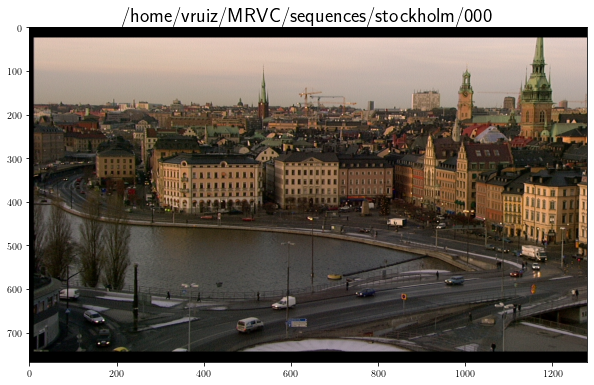

In [7]:
show_frame(frame, fn)

In [8]:
def show_gray_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame, cmap='gray')

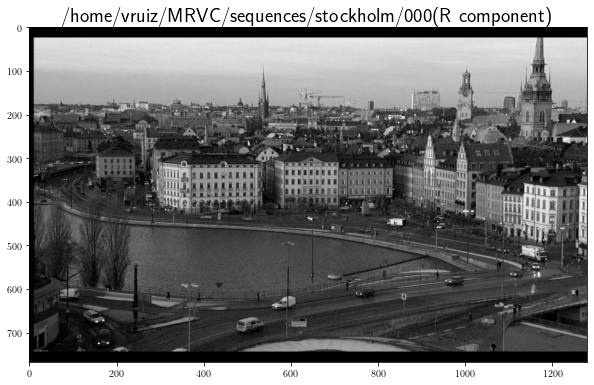

In [9]:
show_gray_frame(frame[:,:,0], fn + "(R component)")

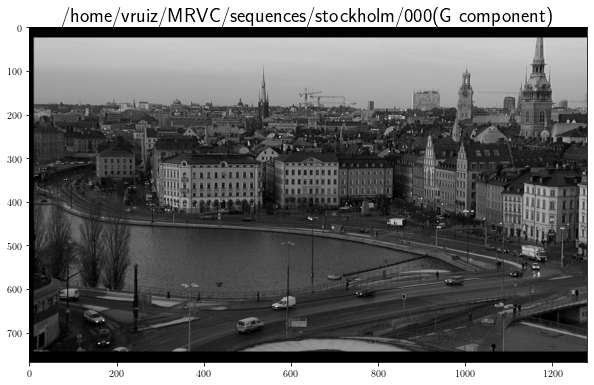

In [10]:
show_gray_frame(frame[:,:,1], fn + "(G component)")

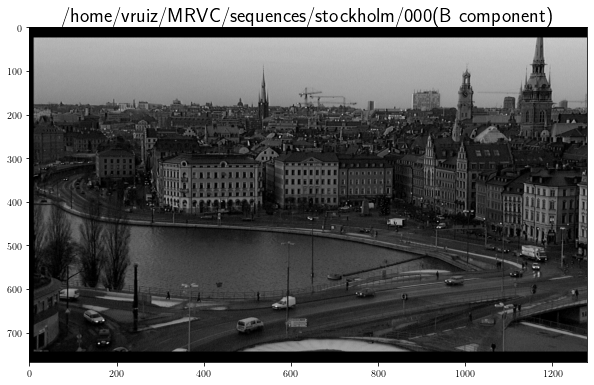

In [11]:
show_gray_frame(frame[:,:,2], fn + "(B component)")

In [13]:
def RGB_to_YCrCb(RGB_frame):
    # Remember that cv2.cvtColor only works with unsigneds!
    YCrCb_frame = cv2.cvtColor(RGB_frame, cv2.COLOR_RGB2YCR_CB)
    return YCrCb_frame

def YCrCb_to_RGB(YCrCb_frame):
    RGB_frame = cv2.cvtColor(YCrCb_frame, cv2.COLOR_YCR_CB2RGB)
    return RGB_frame

def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] = R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] = R/2 - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

def YCoCg_to_RGB(YCoCg_frame):
    Y, Co, Cg = YCoCg_frame[:,:,0], YCoCg_frame[:,:,1], YCoCg_frame[:,:,2]
    RGB_frame = np.empty_like(YCoCg_frame)
    RGB_frame[:,:,0] = Y + Co - Cg 
    RGB_frame[:,:,1] = Y      + Cg
    RGB_frame[:,:,2] = Y - Co - Cg
    return RGB_frame

### Is the YCrCb reversible?

In [14]:
YCrCb = RGB_to_YCrCb(frame.astype(np.uint8))
frame2 = YCrCb_to_RGB(YCrCb)
assert frame.all() == frame2.all(), "The transform is NOT reversible"
print(frame.max(), frame.min())
print(YCrCb.max(), YCrCb.min(), np.average(YCrCb))

255 0
253 0 112.0066630045573


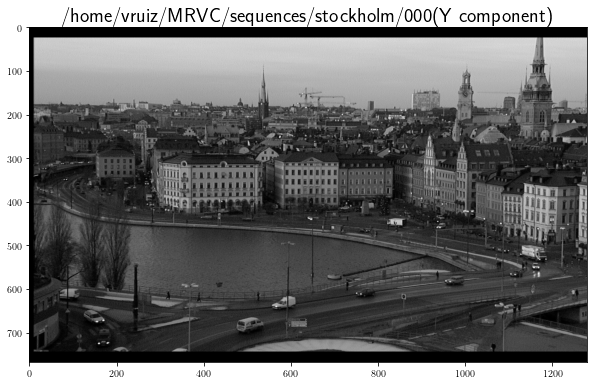

In [15]:
show_gray_frame(YCrCb[:,:,0], fn + "(Y component)")

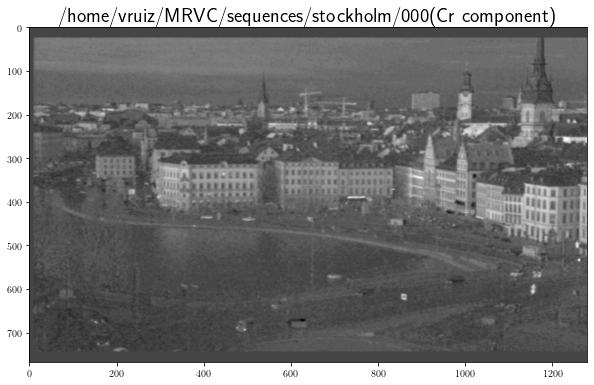

In [16]:
show_gray_frame(YCrCb[:,:,1], fn + "(Cr component)")

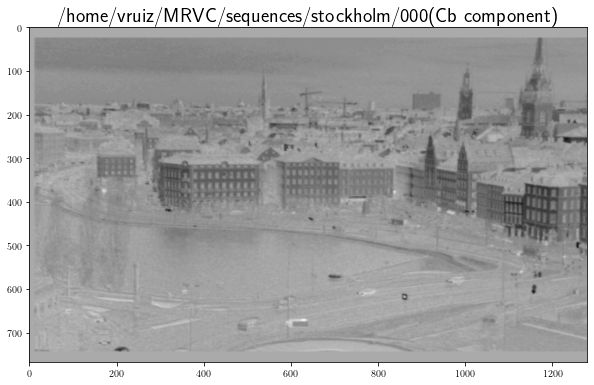

In [17]:
show_gray_frame(YCrCb[:,:,2], fn + "(Cb component)")

### Is the YCoCg reversible?

In [18]:
YCoCg = RGB_to_YCoCg(frame)
frame2 = YCoCg_to_RGB(YCoCg)
assert frame.all() == frame2.all(), "The transform is NOT reversible"
print(frame.max(), frame.min())
print(YCoCg.max(), YCoCg.min(), np.average(YCoCg))

255 0
253 -38 29.832698906792533


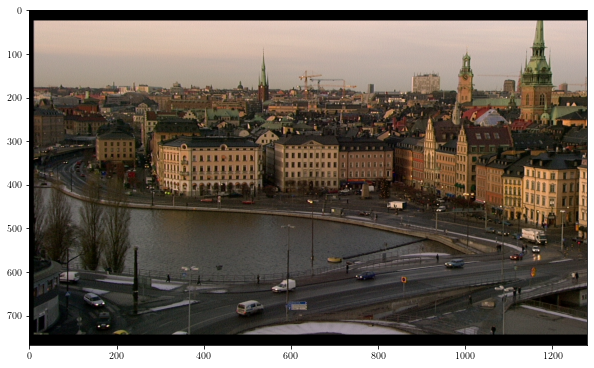

In [19]:
show_frame(frame, "")

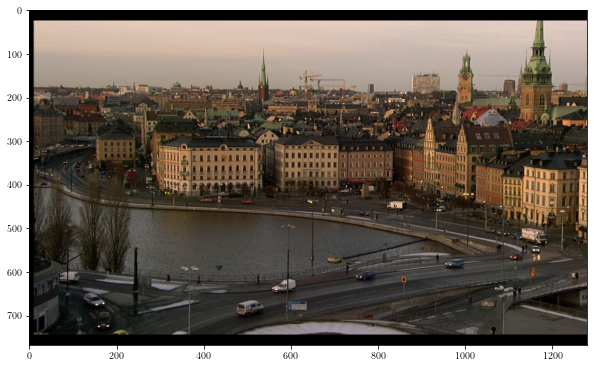

In [20]:
show_frame(frame2, "")

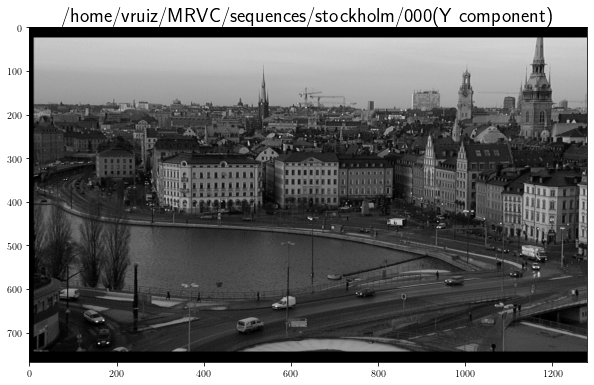

In [21]:
show_gray_frame(YCoCg[:,:,0], fn + "(Y component)")

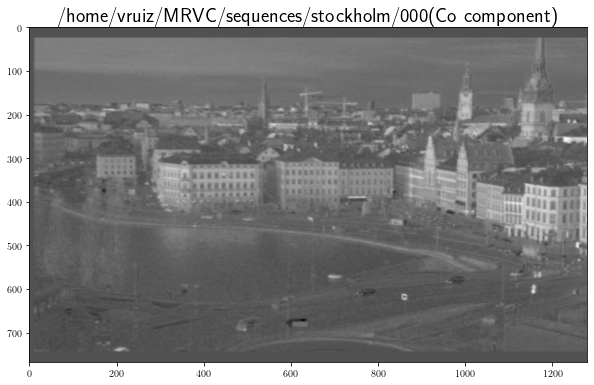

In [22]:
show_gray_frame(YCoCg[:,:,1], fn + "(Co component)")

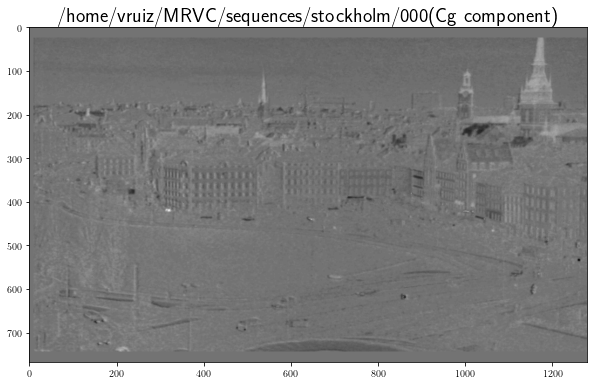

In [23]:
show_gray_frame(YCoCg[:,:,2], fn + "(Cg component)")

## RD stuff

### Rate measurement

In [24]:
def bytes_per_frame(frame):
    write_frame(frame, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

### Distortion measurement

In [25]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

## Synthesis gains
Compute the energy of the synthesis filters.

In [27]:
delta_YCrCb = np.array([100,0,0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB)
print("Y gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([0,100,0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB)
print("Cr gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([0,0,100]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB)
print("Cb gain =", average_energy(delta_RGB))

delta_YCrCb = np.array([100,100,100]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCrCb_to_RGB(delta_YCrCb)
print("delta_YCrCb =", delta_YCrCb, "delta_RGB =", delta_RGB)
print("Total gain =", average_energy(YCrCb_to_RGB(delta_RGB)))

delta_YCrCb = [[[100   0   0]]] delta_RGB = [[[  0 235   0]]]
Y gain = 55225.0
delta_YCrCb = [[[  0 100   0]]] delta_RGB = [[[ 0 64  0]]]
Cr gain = 4096.0
delta_YCrCb = [[[  0   0 100]]] delta_RGB = [[[  0 101   0]]]
Cb gain = 10201.0
delta_YCrCb = [[[100 100 100]]] delta_RGB = [[[ 61 130  50]]]
Total gain = 11492.0


As we can see, the energy of the components in the YCrCb domain is not additive (the same must happen with the distortion).

In [29]:
delta_YCoCg = np.array([100,0,0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB)
print("Y gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([0,100,0]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB)
print("Cr gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([0,0,100]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB)
print("Cb gain =", average_energy(delta_RGB))

delta_YCoCg = np.array([100,100,100]).astype(np.uint8).reshape(1,1,3)
delta_RGB = YCoCg_to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "delta_RGB =", delta_RGB)
print("Total gain =", average_energy(YCoCg_to_RGB(delta_RGB)))

delta_YCoCg = [[[100   0   0]]] delta_RGB = [[[100 100 100]]]
Y gain = 30000.0
delta_YCoCg = [[[  0 100   0]]] delta_RGB = [[[100   0 156]]]
Cr gain = 34336.0
delta_YCoCg = [[[  0   0 100]]] delta_RGB = [[[156 100 156]]]
Cb gain = 58672.0
delta_YCoCg = [[[100 100 100]]] delta_RGB = [[[100 200 156]]]
Total gain = 20736.0


With the YCoCg happens the same (the components are not additive).

### Energy of the RGB channels

In [30]:
R_energy = average_energy(frame[:,:,0])
G_energy = average_energy(frame[:,:,1])
B_energy = average_energy(frame[:,:,2])
print("Energy of R =", R_energy)
print("Energy of G =", G_energy)
print("Energy of B =", B_energy)

Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625


### Energy of the YCrCb channels

In [31]:
YCrCb = RGB_to_YCrCb(frame.astype(np.uint8))
Y_energy = average_energy(YCrCb[:,:,0])
Cr_energy = average_energy(YCrCb[:,:,1])
Cb_energy = average_energy(YCrCb[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Cr =", Cr_energy)
print("Energy of Cb =", Cb_energy)

Energy of Y = 13027202.493489584
Energy of Cr = 23271441.41015625
Energy of Cb = 18649035.940104168


### Energy of the YCoCg channels

In [32]:
YCoCg = RGB_to_YCoCg(frame)
Y_energy = average_energy(YCoCg[:,:,0])
Co_energy = average_energy(YCoCg[:,:,1])
Cg_energy = average_energy(YCoCg[:,:,2])
print("Energy of Y =", Y_energy)
print("Energy of Co =", Co_energy)
print("Energy of Cg =", Cg_energy)

Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667


The energy is more concentrated in the YCoCg domain, more specifically in the Y channel.

### RD using (only) quantization in the RGB domain ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}}$)

In [33]:
def only_Q_RD_curve(x):
    points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        k, y = q_deq(x, 1<<q_step)
        rate = bytes_per_frame(k)
        distortion = RMSE(x, y)
        points.append((rate, distortion))
    return points

RGB_points = only_Q_RD_curve(frame)

0 1 2 3 4 5 6 7 

### RD using quantization in the YCbCr domain ($\Delta_{\text{Y}} = \Delta_{\text{Cr}} = \Delta_{\text{Cb}}$)

In [34]:
def YCrCb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        k, dequantized_YCrCb_frame = q_deq(YCrCb_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame.astype(np.uint8))
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCrCb_points = YCrCb_RD_curve(frame)

0 1 2 3 4 5 6 7 

In [35]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YYCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = bytes_per_frame(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YYCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(frame)

0 1 2 3 4 5 6 7 

In [36]:
def YCoCg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCoCg_points = YCoCg_RD_curve(frame)

0 1 2 3 4 5 6 7 

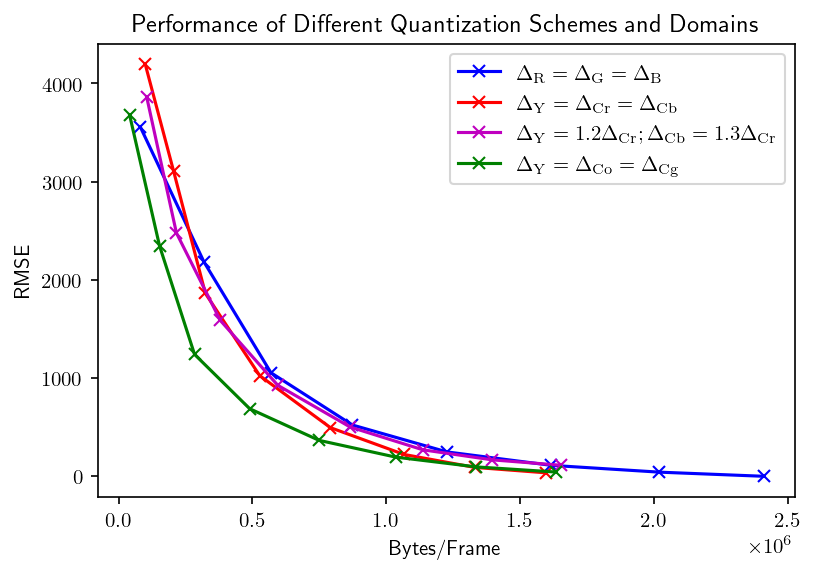

In [37]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Different Quantization Schemes and Domains")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [38]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = RGB_to_YCrCb(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb_to_RGB(dequantized_YCrCb_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Cb_points = only_Cb_RD_curve(frame)
only_Cr_points = only_Cr_RD_curve(frame)

0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 

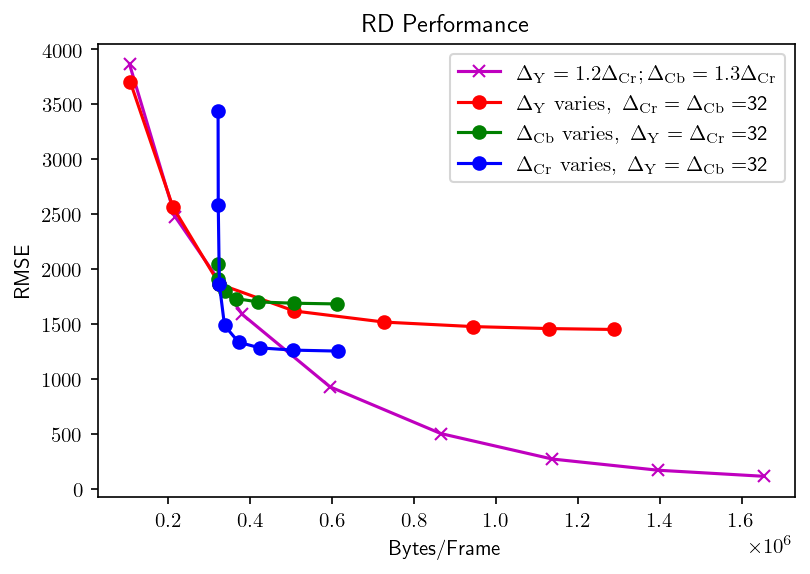

In [41]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [44]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bytes_per_frame(k)
        dequantized_RGB_frame = YCoCg_to_RGB(dequantized_YCoCg_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(frame)
only_Co_points = only_Co_RD_curve(frame)
only_Cg_points = only_Cg_RD_curve(frame)

0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 

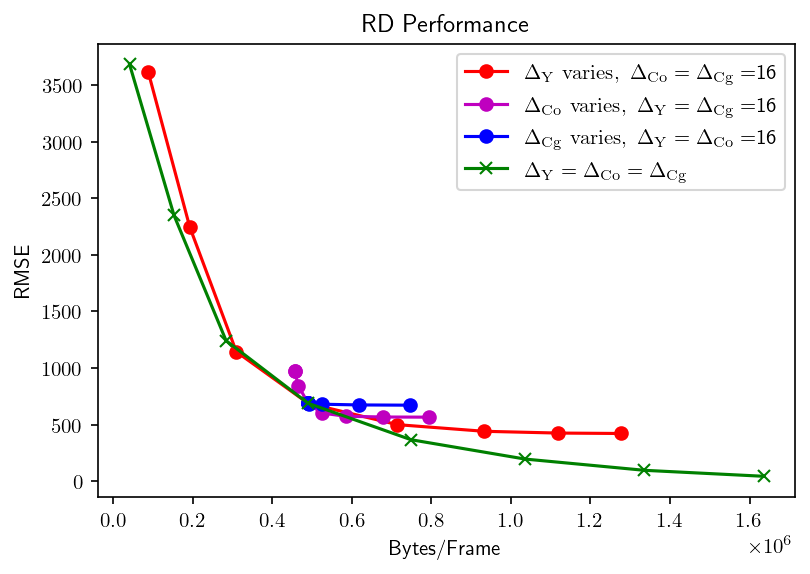

In [45]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment that before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")